# 模型结构

> 宏伟与绝对，那令人不能质疑的光辉权威。

我们这样组织我们的模型，首先所有replay是由一个玩家使用一个策略通过执行，或者说游弈而成。这个策略总有不完美之处，但作为L级的replay，
还是有其科学之处。那么我们可以把所有可观测变量都看成某种计划和执行力的带随机扰动（当然replay经常是大量重复试验中最好的那些，
捕捉这一点虽然很有趣，但以当前的信息似乎很难推断出来，），它们本身服从某种分布，其参数可以是随机的或者固定的，
它们对每个replay格在一次实现中指定策略和执行力，这个值可以是连续或离散的，可以分开个或合为一个或更加复杂。

一个策略和执行力下决定了其在各个情景的行为方式，我们这里姑且认为各个情景的行为在给定策略和执行力下是条件独立的，虽然这并不全然正确，
比如如果在之前的残机损失过多，也许一个激进的策略会变得相对保守，但这里我们不考虑这种相关性。

假如这个条件独立性可以被假设，我们是否可以进一步假设它在各个frame或各个1s上个各个表现也是独立的呢？看上去不太行，
时间段之间的行为是紧密相关的，它们合在一起表示了某种目的，当然合并的越厉害这个相关性越消除，到一个stage合并成一个时，
就不需要考虑这个了。当然这是不可接受的。

我们可以把道中和boss的各个符卡与对话式停顿进一步分解成一些相对的独立的单元。这取代stage成为策略下能完全条件独立的基本单元。
与stage不同的是，各时间格对各个符卡，对话与道中的隶属关系是观测不到的。而且，基于这个原则我们就可以直接给出“类数”
与推荐的初始值（通过一些策略的探索式分析给出），简化我们的优化算法。

一个情景内的z与x都可以考虑为策略与请进的笛卡尔积参数控制的独立的随机变量（虽然这里暗示着表格，但可以降维成更简单的情况）。
其中z主要集中在60与0上，我们可以干脆使用连续近似对抽样进行优化，x则是集中在0的泊松分布之类的。它们的参数是策略，执行力与情景
（情景作为分类变量或情景的参数，试我们如何编码情景）。



# 跨replay的探索

基于ctrl粗略划分出间隔点，考察到达那些时间点的位置的分布与更简单的,frame的分布将是很有意义的信息。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from explore_tool import load_info,press,pressing,frame_to_delta,replay_to_xy,plot_trace_2d,plot_trace_3d,plot_trace_sequence,summary,\
    load_infos

In [2]:
import os

In [3]:
%%time
infos = load_infos('replay_int16/RB')
# 结果被迫优化读取方式以免卡爆内存

Wall time: 11 s


In [7]:
info_list = list(infos.values())

In [10]:
info = infos['th10_ud000c.rpy.json.pickle']

In [11]:
def look_pressing(key, info, press = False):
    for i in range(info['stage']):
        stage = info['stages'][i]
        df = stage['replay']
        groupby = df['{}_{}'.format('press' if press else 'pressing', key)].groupby(df.index.map(lambda t: t//60))
        gs = groupby.sum()
        #gs.plot()
        plt.fill_between(np.arange(len(gs)),gs)
        plt.ylim(-1,61)
        plt.title('stage {}'.format(i+1))
        #plt.legend()
        plt.show()
        
def look_pressing_shift(info):
    look_pressing('shift', info)

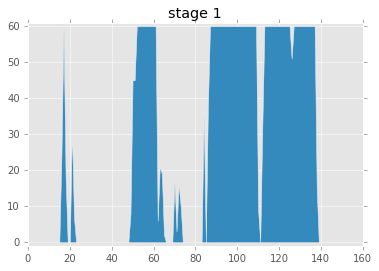

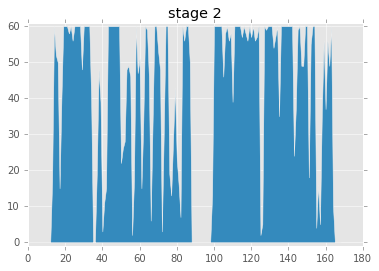

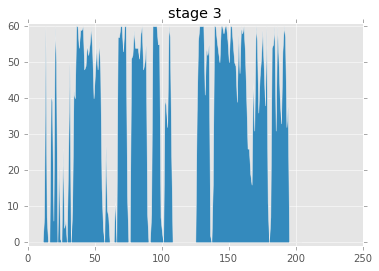

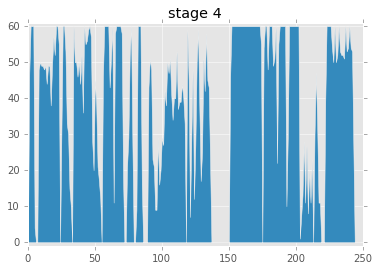

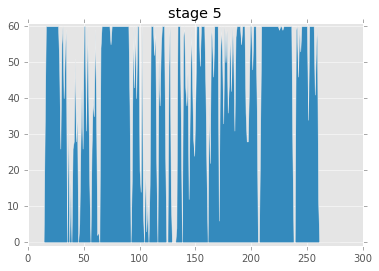

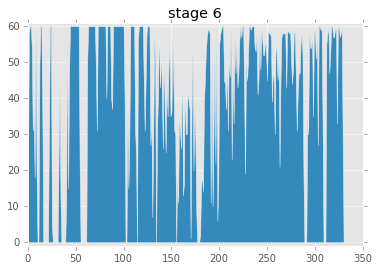

In [12]:
look_pressing('shift', info)

看起来缓存没引发新的Bug...

In [15]:
def show_stage_frame_hist(info_list):
    for i in range(6):
        frame_list = []
        for info in info_list:
            frame_list.append(info['stages'][i]['frame'])
        plt.hist(frame_list,normed=True)
        plt.title('stage {} frame hist'.format(i+1))
        plt.show()

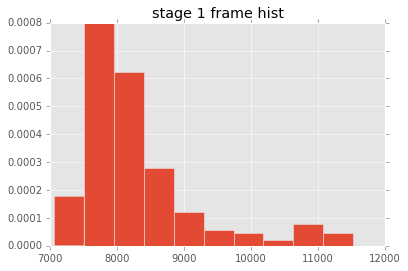

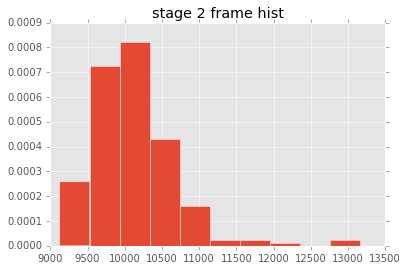

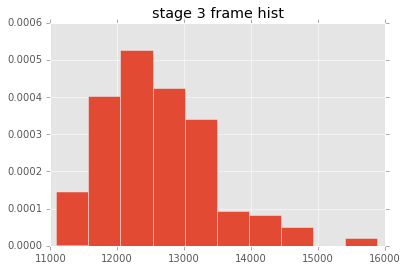

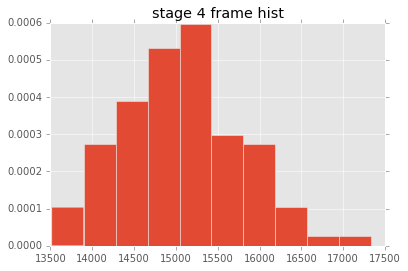

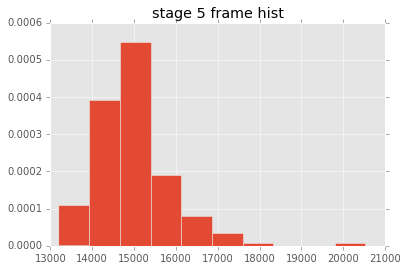

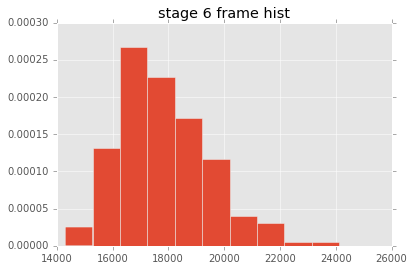

In [16]:
show_stage_frame_hist(info_list)

In [19]:
def show_stage_score_hist(info_list):
    for i in range(6):
        frame_list = []
        for info in info_list:
            frame_list.append(info['stages'][i]['score'])
        plt.hist(frame_list,normed=True)
        plt.title('stage {} score hist'.format(i+1))
        plt.show()
        


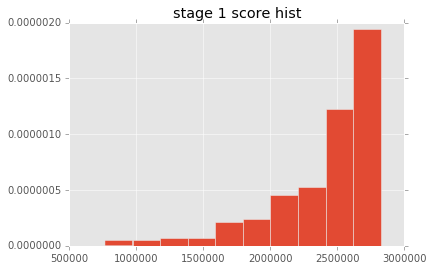

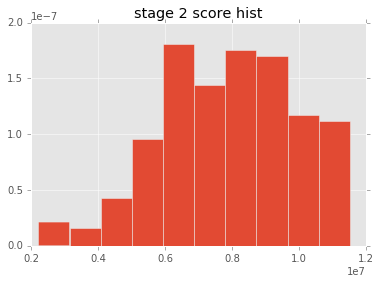

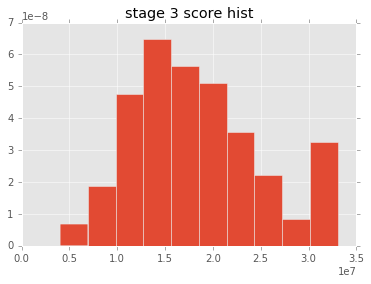

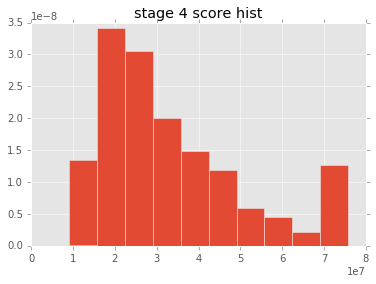

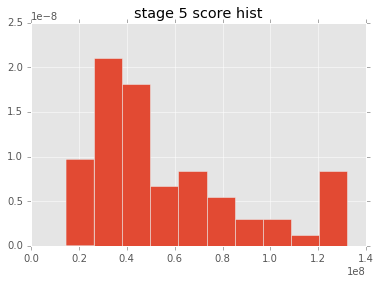

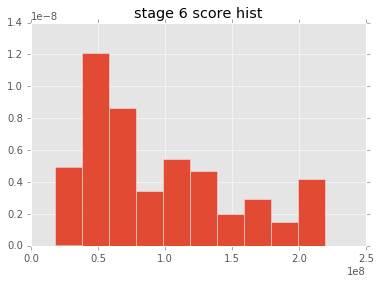

In [20]:
show_stage_score_hist(info_list)

看起来frame还比较正常，并且从中可以看到策略的差别。我们知道为了刷分而拖时间为了无创而速攻之类的不同的目标和策略最后当然会合成出不同的stage时间。

分数（好像是累积分数）的分布非常有趣，这个峰从右往左的移动似乎蕴含着某种统计规律的体现，但我一下想不出是怎么回事。
是否很多个第一个stage那种分布叠起来就变成stage6那种了？

那么是否一个回放里一个stage的frame的长与短有助于预测其他stage的长与短呢？也就是说，它们的相关性如何？是否同长同短？



In [36]:
def frame_corr(info_list):
    x = np.zeros((6,len(info_list)))
    for i,info in enumerate(info_list):
        for j in range(6):
            x[j,i] = info['stages'][j]['frame']
    return np.corrcoef(x)

In [37]:
frame_corr(info_list)

array([[ 1.        ,  0.34165219,  0.29264188,  0.2794666 ,  0.21240139,
        -0.15160775],
       [ 0.34165219,  1.        ,  0.3495886 ,  0.26887412,  0.20318896,
        -0.0238966 ],
       [ 0.29264188,  0.3495886 ,  1.        ,  0.46877097,  0.30314982,
         0.11592111],
       [ 0.2794666 ,  0.26887412,  0.46877097,  1.        ,  0.36625073,
         0.1552958 ],
       [ 0.21240139,  0.20318896,  0.30314982,  0.36625073,  1.        ,
         0.21206054],
       [-0.15160775, -0.0238966 ,  0.11592111,  0.1552958 ,  0.21206054,
         1.        ]])

这个结构和猜想的很不一样。。本来还以为肯定都是很强的正相关，即一个策略贯彻始终自然地结果。但是这个stage之间只与邻近的相关性很强是什么鬼。。
暗示了某种策略变动的结果吗。。起码我可以拿这个说事。什么跨stage间存在策略状态的转移之类的。

In [44]:
def score_corr(info_list, diff = False):
    x = np.zeros((6,len(info_list)))
    for i,info in enumerate(info_list):
        for j in range(6):
            x[j,i] = info['stages'][j]['score']
            if diff and j >= 1:
                x[j,i] -= x[j-1,i]
    return np.corrcoef(x)

In [45]:
score_corr(info_list)

array([[ 1.        ,  0.84107833,  0.71341541,  0.59023452,  0.56472215,
         0.56037327],
       [ 0.84107833,  1.        ,  0.94881721,  0.87185622,  0.84881359,
         0.82631619],
       [ 0.71341541,  0.94881721,  1.        ,  0.95625263,  0.9336515 ,
         0.91003447],
       [ 0.59023452,  0.87185622,  0.95625263,  1.        ,  0.98992673,
         0.95447088],
       [ 0.56472215,  0.84881359,  0.9336515 ,  0.98992673,  1.        ,
         0.97245266],
       [ 0.56037327,  0.82631619,  0.91003447,  0.95447088,  0.97245266,
         1.        ]])

In [46]:
score_corr(info_list,diff=True)

array([[ 1.        ,  0.76474429,  0.68388725,  0.53690595,  0.57522655,
         0.54110131],
       [ 0.76474429,  1.        ,  0.93136767,  0.86321008,  0.8757295 ,
         0.82118502],
       [ 0.68388725,  0.93136767,  1.        ,  0.91872629,  0.93648584,
         0.88333907],
       [ 0.53690595,  0.86321008,  0.91872629,  1.        ,  0.97011367,
         0.91759795],
       [ 0.57522655,  0.8757295 ,  0.93648584,  0.97011367,  1.        ,
         0.94354785],
       [ 0.54110131,  0.82118502,  0.88333907,  0.91759795,  0.94354785,
         1.        ]])

看起来除了第一关外的得分策略倒是非常相关，而且这里就不是邻近的更相关的结构了。

上一个notebook我们考察了ctrl的分割作用，现在我们看看ctrl在所有stage直接按info合在一起后的分布以及做一些初级的对齐后的分布。

In [50]:
frame_matrix = np.array([[info['stages'][i]['frame'] for i in range(6)] for info in info_list])

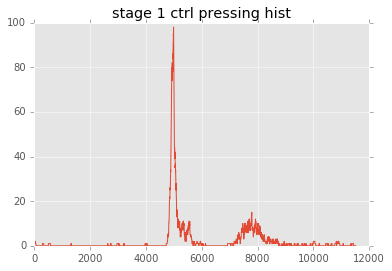

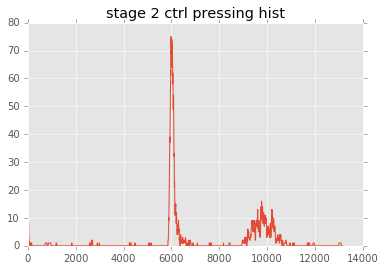

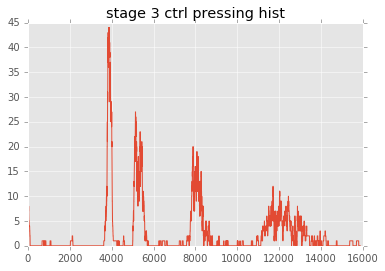

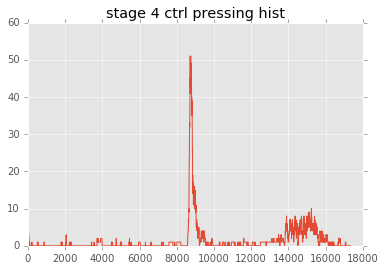

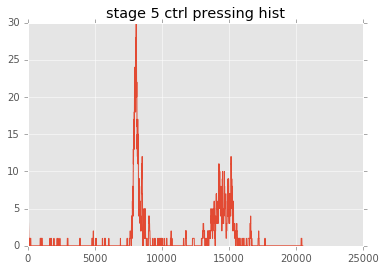

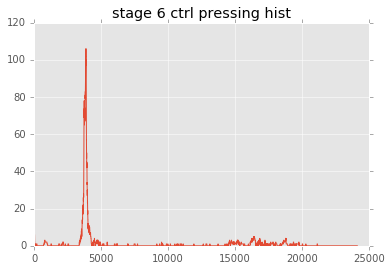

In [56]:
for i,max_frame in enumerate(frame_matrix.max(axis=0)):
    arr = np.zeros(max_frame)
    for info in info_list:
        add = np.zeros(max_frame)
        pressing_ctrl = info['stages'][i]['replay']['pressing_ctrl']
        add[:len(pressing_ctrl)] = pressing_ctrl
        arr += add
    plt.plot(arr)
    plt.title('stage {} ctrl pressing hist'.format(i+1))
    plt.show()

这个模式很有意思，即使没哟进行任何对齐（甚至没有frame级的对齐），也显示出了令人感兴趣的模式。可以看到因为早期的道中的时间差异不大，
所以分布紧密分布在类似的位置，尔后随着打符卡的策略不同，分布开始摊散开来，而且越摊越开，这从stage3打河城荷取中可以最明显看出来。

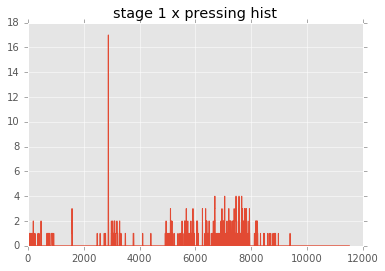

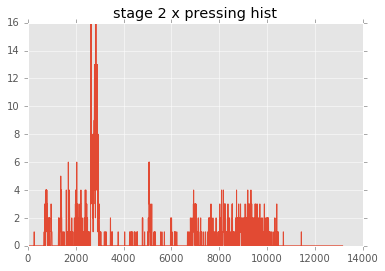

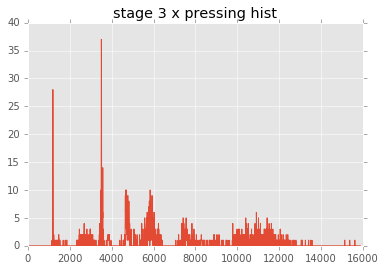

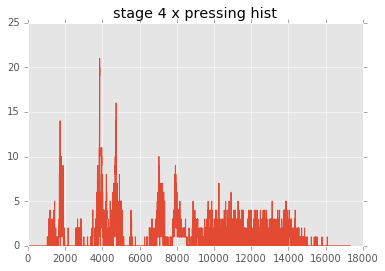

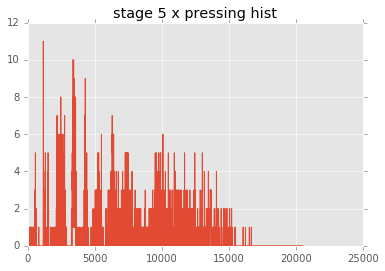

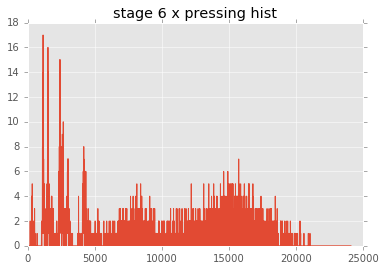

In [58]:
for i,max_frame in enumerate(frame_matrix.max(axis=0)):
    arr = np.zeros(max_frame)
    for info in info_list:
        add = np.zeros(max_frame)
        pressing_ctrl = info['stages'][i]['replay']['pressing_x']
        add[:len(pressing_ctrl)] = pressing_ctrl
        arr += add
    plt.plot(arr)
    plt.title('stage {} x pressing hist'.format(i+1))
    plt.show()

In [66]:
def show_pressing_in_time(info_list, key, frame = True, second = 60):
    # anyway... if frame is False, we will merge second ( perhap the second should be 'frames' ... ) frame into a item
    frame_matrix = np.array([[info['stages'][i]['frame'] for i in range(6)] for info in info_list])

    if frame:
        for i,max_frame in enumerate(frame_matrix.max(axis=0)):
            arr = np.zeros(max_frame)
            for info in info_list:
                add = np.zeros(max_frame)
                ser = info['stages'][i]['replay'][key]
                pressing = ser
                add[:len(pressing)] = pressing
                arr += add
            plt.plot(arr)
            plt.title('stage {} {} count'.format(i+1, key))
            plt.show()
    else:
        for i,max_frame in enumerate(frame_matrix.max(axis=0)):
            arr = np.zeros(max_frame//second+1)
            for info in info_list:
                add = np.zeros(max_frame//second+1)
                ser = info['stages'][i]['replay'][key]
                pressing = ser.groupby(ser.index.map(lambda t:t//second)).sum()
                add[:len(pressing)] = pressing
                arr += add
            plt.plot(arr)
            plt.title('stage {} {} count ({} frame)'.format(i+1, key, second))
            plt.show()


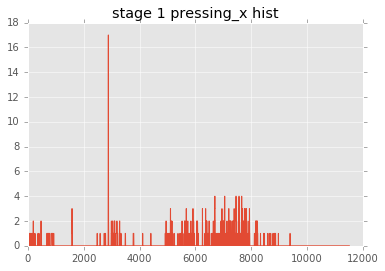

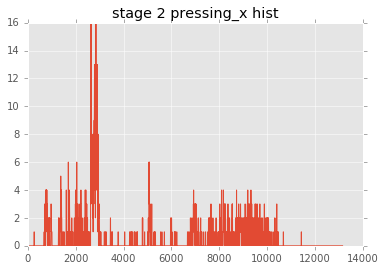

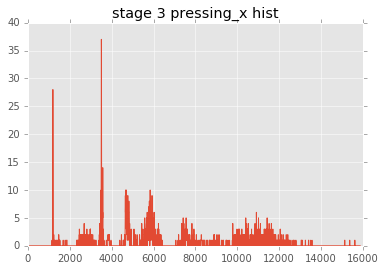

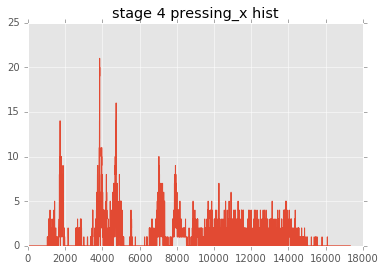

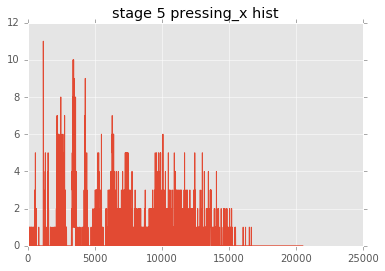

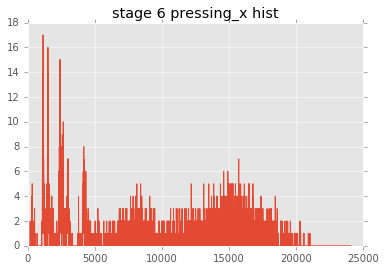

In [64]:
show_pressing_in_time(info_list, 'pressing_x')

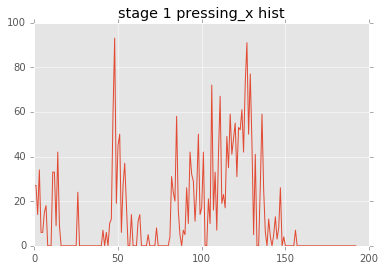

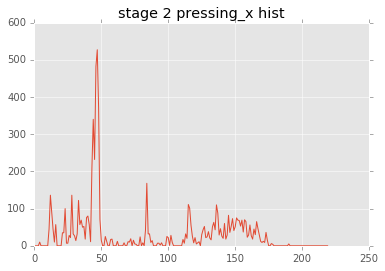

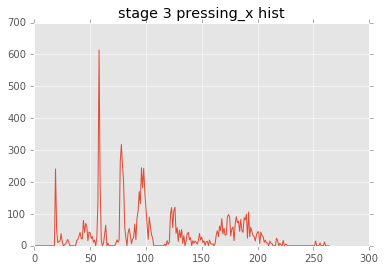

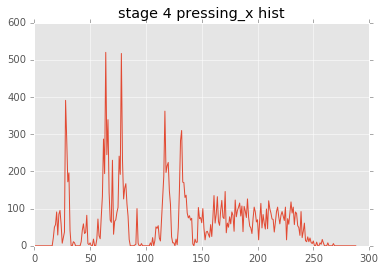

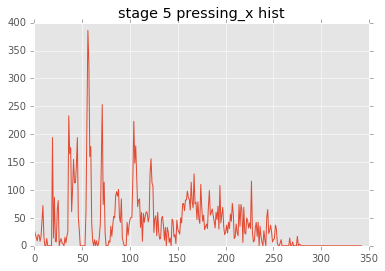

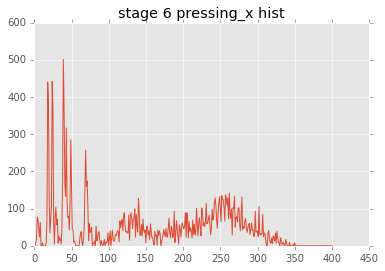

In [65]:
show_pressing_in_time(info_list, 'pressing_x', frame = False)

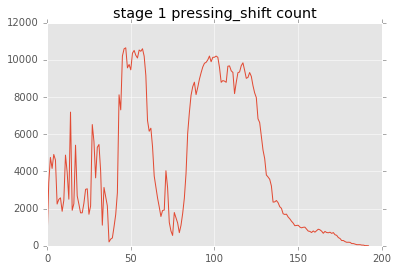

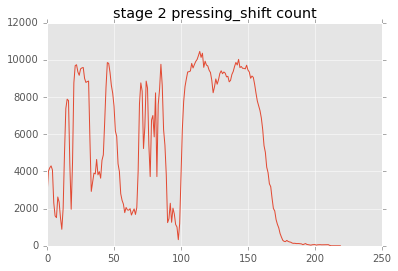

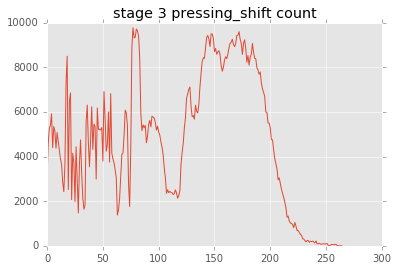

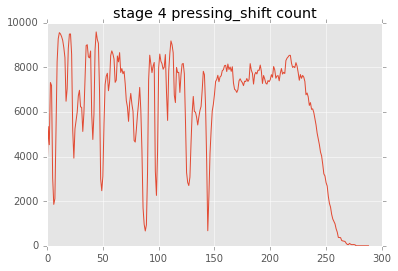

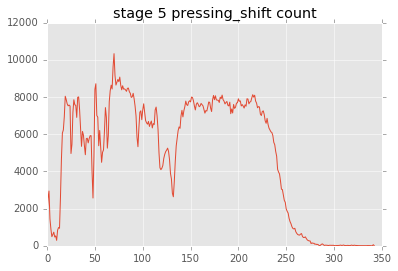

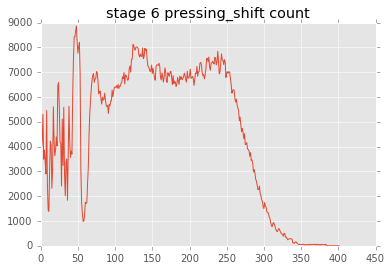

In [67]:
show_pressing_in_time(info_list, 'pressing_shift', frame = False)

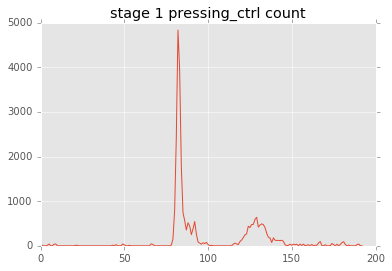

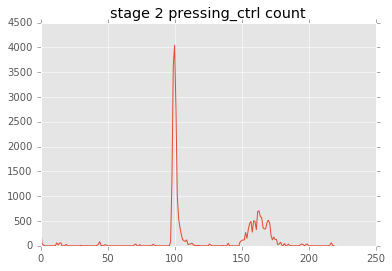

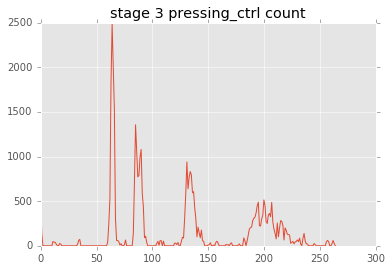

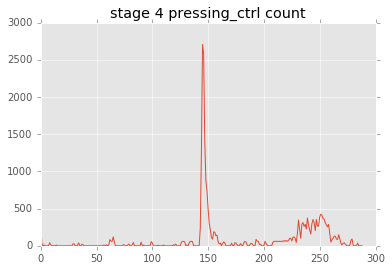

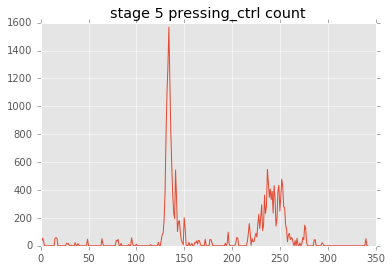

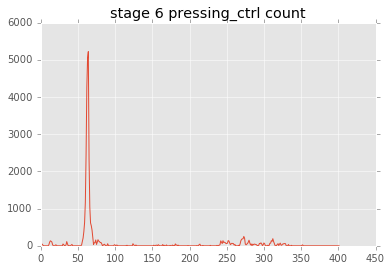

In [68]:
show_pressing_in_time(info_list, 'pressing_ctrl', frame = False)